# DogsVsCats

Dataset origin: https://www.kaggle.com/c/dogs-vs-cats/  

Download preprocessed data here:  
* cats: https://jonneokkonen.com/data/cats_vs_dogs_train_cats.npy  
* dogs: https://jonneokkonen.com/data/cats_vs_dogs_train_dogs.npy  

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 28 18:03:15 2020

@author: Jonne Okkonen
"""

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.image import imread
import cv2
import os
import random
import time
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import accuracy_score

NAME = "Cats-vs-dog-cnn-120_80_60_30_v1_{}".format(int(time.time()))
tb = TensorBoard(log_dir='logs\\{}'.format(NAME))
imageSize = 128

# Check if GPU available
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices): 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)
print("GPU available:", len(physical_devices))

[]
GPU available: 0


In [ ]:
# ======== IMAGE PREPROCESSING ========

# Preprocess images (convert to numpy array and rescale)
def ImagePreprocessing(path, fileName = ""):
    if(fileName == ""): fileName = path
    x_data = []
    count = 0
    directory =  os.listdir(path)
    for img in directory: 
        # Read Image and Resize to (128, 128)
        image = cv2.resize(src=imread(path + "/" + img), dsize=(imageSize, imageSize), interpolation=cv2.INTER_LINEAR)
        # Add Image to numpy array
        x_data.append([image, img.split(".")[0]])
        count += 1
        if (count % int(len(directory) / 40)) == 0:
            print(fileName, count, "/", len(directory), "done")
    np.save(fileName + ".npy", x_data, allow_pickle=True)
    print(fileName, "Done.")

# Process Cat images
ImagePreprocessing("cats_vs_dogs_train_cats")
# Process Dog images
ImagePreprocessing("cats_vs_dogs_train_dogs")

In [6]:
# ======== LOAD DATA ========

# Load values from file and reshape
x_cats = np.load("cats_vs_dogs_train_cats.npy", allow_pickle=True).reshape(-1, 2)
x_dogs = np.load("cats_vs_dogs_train_dogs.npy", allow_pickle=True).reshape(-1, 2)
print("Data loaded.")


Data loaded.


In [9]:
# ======== DATA PROCESSING ========

# Divide data to cats and dogs, combine arrays
x_test = np.append(x_cats[:2000], x_dogs[:2000]).reshape(-1, 2)
x_train = np.append(x_cats[2000:], x_dogs[2000:]).reshape(-1, 2)

# Shuffle training/testing data
np.random.shuffle(x_train)
np.random.shuffle(x_test)

# Split labels to its own array
def SplitData(array):
    x_data = []
    y_data = []
    for img, label in array:
        x_data.append(img)
        y_data.append(label)
    # Convert to numpy array
    return np.array(x_data), np.array(y_data)

x_test, y_test = SplitData(x_test)
x_train, y_train = SplitData(x_train)

# Scale rgb values 0-255 to 0-1
x_test = x_test / 255
x_train = x_train / 255

print("Data processed")

Data processed


Labels Reformatted


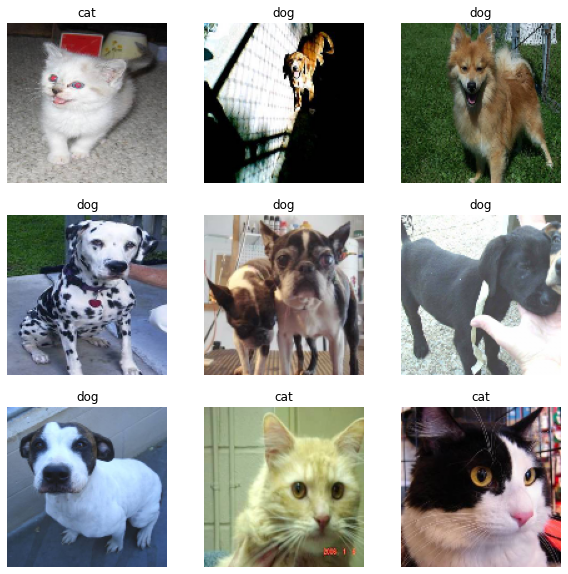

In [10]:
# ======== PREVIEW DATA ========

# Show 9 random training images
plt.figure(figsize=(10, 10))
for i in range(0, 9):
    rnd = random.randint(0, len(x_train))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[rnd])
    plt.title(y_train[rnd])
    plt.axis("off")

# Reformat label data
y_test = pd.get_dummies(y_test)
y_train = pd.get_dummies(y_train)

print("Labels Reformatted")

In [ ]:
# ======== TRAINING ========

# Create, train and save model
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(80, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(60, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(30, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
        ])

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['categorical_accuracy'])

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=25, callbacks=[tb])

model.save("models/cats_vs_dogs_model_v1.h5")

Train on 21000 samples, validate on 4000 samples
Epoch 1/5


In [ ]:
# Continue Training
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1, batch_size=25, callbacks=[tb])

# Save Model
model.save("models/cats_vs_dogs_model_v2_2.h5")

In [7]:
# ======== LOAD MODEL ========

model = tf.keras.models.load_model('models/cats_vs_dogs_model_86_83.h5')
print("Model Loaded")


Model Loaded


In [11]:
# ======== RESULTS ========

classes = ["cat", "dog"]

# Calculate Training Accuracy
train_predictions = np.argmax(model.predict(x_train), axis=1)
train_labels = y_train.idxmax(axis=1).map({"cat": 0, "dog": 1})
print("Training Accuracy:", accuracy_score(train_labels, train_predictions))

# Calculate Testing Accuracy
predictions_raw = model.predict(x_test)
predictions = np.argmax(predictions_raw, axis=1)
labels = y_test.idxmax(axis=1).map({"cat": 0, "dog": 1})
print("Test Accuracy:", accuracy_score(labels, predictions))

# Classify images to right and wrong
right = []
wrong = []
for i in range(0, len(x_test)):
    if(labels[i] == predictions[i]):
        right.append([x_test[i], classes[predictions[i]], predictions_raw[i]])
    else:
        wrong.append([x_test[i], classes[predictions[i]], predictions_raw[i]])

print("Right: ", len(right), " | Wrong: ", len(wrong))

Training Accuracy: 0.9242857142857143
Test Accuracy: 0.86825
Right:  3473  | Wrong:  527


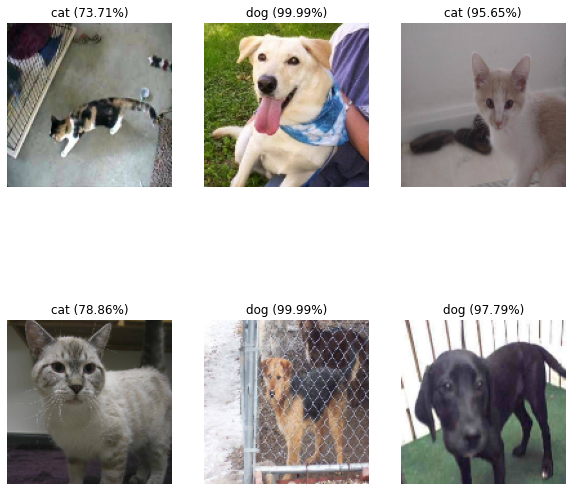

In [18]:
# ======== Show 6 correctly classified images ========

plt.figure(figsize=(10, 10))
for i in range(0, 6):
    rnd = random.randint(0, len(right))
    accuracy = np.round(np.max(right[rnd][2]) * 100, 2)
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(right[rnd][0])
    plt.title(right[rnd][1] + " (" + str(accuracy) + "%)")
    plt.axis("off")

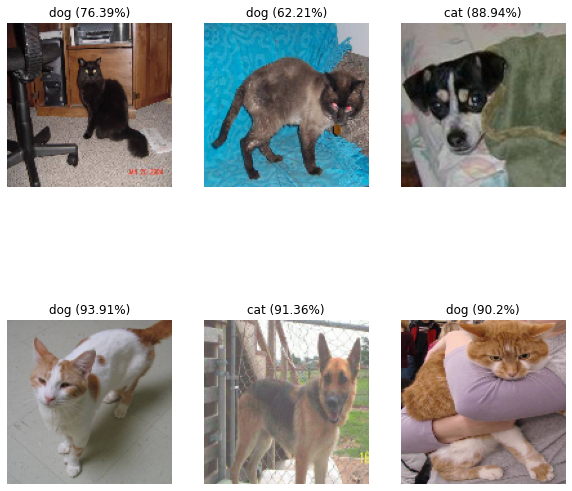

In [19]:
# ======== Show 6 incorrectly classified images ========

plt.figure(figsize=(10, 10))
for i in range(0, 6):
    rnd = random.randint(0, len(wrong))
    accuracy = np.round(np.max(wrong[rnd][2]) * 100, 2)
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(wrong[rnd][0])
    plt.title(wrong[rnd][1] + " (" + str(accuracy) + "%)")
    plt.axis("off")

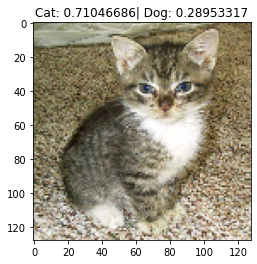

In [24]:
# ======== Predict Single Images ========

# Read Image and Resize to (128, 128), Predict
img = "testImages/cat.jpg"
#img = "testImages/dog.jpg"
testImage = cv2.resize(src=imread(img), dsize=(imageSize, imageSize), interpolation=cv2.INTER_LINEAR) / 255
result = model.predict(testImage.reshape(-1, 128, 128, 3))[0]

# Show Image with results
plt.figure()
plt.imshow(testImage)
plt.title("Cat: " + str(result[0]) + "| Dog: " + str(result[1]))
plt.show()